# Landcover and Landform Classification with deep neural networks

## *Virtual* "CSDMS 2020 - Linking Ecosphere and Geosphere". May 20th and 21st, 2020.

-----------------------------
### Day 2: using a binary image segmentation model for a multiclass segmentation problem 

Before you do anything, go to `File > Save copy in Drive` so you can keep and work on your own copy

In the first part we made a deep convolutional neural network model, specifically a U-Net with residual connections. This is a very useful model framework for landscape scale image segmentation, because it learns both low-level and high-level feature representations of the data, capturing both low- to high-resolution continuum of landscape detail. We saw how well it works on segmenting vegetation in a couple of different aerial (UAV) datasets.

In this part, we will take that model and optimize it for a particular dataset and a multiclass segmentation problem, by combining UNets for individual classes.

I will hopefully convince you of the benefits of a specific approach for segmentation of natural scenery; namely, treating classifications as a series of binary decisions. We'll treat each class separately by considering it against a background of "everything else". That way, we can evaluate each class independently, decide of what classes to use, and we have more options to evaluate what happens in regions predicted to be more than one thing.

We'll utilize a few different python workflows 
* Constructing several UNet models each for a separate class, and loading pre-trained weights to each
* Using a test set to evaluate the skill of each model/class
* Resizing predicted segmentations to full image size
* Post-processing multiclass predictions usig median filters and conditional random fields

All the datasets used in these notebooks are publicly available and explained as they come up in the workflow

-----------------------------------------------
### Daniel Buscombe, daniel@mardascience.com, May 2020

![](https://mardascience.com/wp-content/uploads/2019/06/cropped-MardaScience_logo-5.png)


--------------------------------------------------
## Import libraries

Libraries can be imported at any time, but it is often cleaner to define all the libraries we'll need up front.

In [0]:
import os #for accessing operating system utilities
from glob import glob #for finding files that match a certain string pattern
import matplotlib.pyplot as plt #for plotting
import numpy as np #for numerical operations
from PIL import Image #for image reading
from joblib import Parallel, delayed #for 'embarassingly parallel' computation - more later!
from numpy.lib.stride_tricks import as_strided as ast #cut an array with the given shape and strides
import random, string #for creating random strings
import tensorflow as tf #tensorflow
import requests #for downloading files from the internet
from skimage.transform import resize #for resizing images
from psutil import virtual_memory #for displaying information about GPU and RAM in colab
from matplotlib.colors import ListedColormap
from matplotlib import cm

In [0]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization
from tensorflow.keras.layers import Concatenate, Conv2DTranspose, Flatten, Activation, Add
from tensorflow.keras.models import Model

This first part will replicate the first part of the previous notebook. This time we'll organize our workflow with all our data and model functions defined upfront, then we'll list our user-defined variables, then we'll start training models

The following sections are repeats of the first part of this two-part course, without the explanations. Run through them and I'll see you in a few cells!

----------------------------------------------------------
## Data functions

In [0]:
# from https://stackoverflow.com/questions/38511444/python-download-files-from-google-drive-using-url

def download_file_from_google_drive(id, destination):
    URL = "https://docs.google.com/uc?export=download"

    session = requests.Session()

    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)

    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)

    save_response_content(response, destination)    

def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value

    return None

def save_response_content(response, destination):
    """
    response = filename for input
    destination = filename for output
    """    
    CHUNK_SIZE = 32768

    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)

In [0]:
 def get_pair(f, class_num, sz):
    image = np.array(Image.open(f).resize(sz))

    # open label image by string substitution and resize
    mask = np.array(Image.open(f.replace('.jpg','.png').replace('JPEGImages','SegmentationClass')).resize(sz))
    
    #return 'True' for each pixel equalling the class of interest, then convert that boolean to integer
    mask = (mask==class_num).astype('int') 

    return image, mask

In [0]:
def image_batch_generator(files, class_num, sz, batch_size = 8):
  
  while True: # this is here because it will be called repeatedly by the training function
    
    #extract a random subset of files of length "batch_size"
    batch = np.random.choice(files, size = batch_size)    
    
    #variables for collecting batches of inputs (x) and outputs (y)
    batch_x = []
    batch_y = []
    
    #cycle through each image in the batch
    for f in batch:
        # open the image and resize
        image = np.array(Image.open(f).resize(sz))
        batch_x.append(image) #append to our growing list of images

        # open label image by string substitution and resize
        mask = np.array(Image.open(f.replace('.jpg','.png').replace('JPEGImages','SegmentationClass')).resize(sz))
        
        #return 'True' for each pixel equalling the class of interest, then convert that boolean to integer
        mask = (mask==class_num).astype('int') 
        
        batch_y.append(mask) #add to the list of lasbels

    #turn into numpy arrays and expand the dimensions of the label 
    batch_x = np.array(batch_x) 
    batch_y = np.array(batch_y)
    batch_y = np.expand_dims(batch_y,3) #add singleton dimension to batch_y

    yield (batch_x, batch_y) #yield both the image and the label together

------------------------------------------------------------
## Model functions

In [0]:
def batchnorm_act(x):
    x = BatchNormalization()(x)
    return Activation("relu")(x)

def conv_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    conv = batchnorm_act(x)
    return Conv2D(filters, kernel_size, padding=padding, strides=strides)(conv)

def bottleneck_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    conv = Conv2D(filters, kernel_size, padding=padding, strides=strides)(x)
    conv = conv_block(conv, filters, kernel_size=kernel_size, padding=padding, strides=strides)
    
    bottleneck = Conv2D(filters, kernel_size=(1, 1), padding=padding, strides=strides)(x)
    bottleneck = batchnorm_act(bottleneck)
    
    return Add()([conv, bottleneck])

def res_block(x, filters, kernel_size=(3, 3), padding="same", strides=1):
    res = conv_block(x, filters, kernel_size=kernel_size, padding=padding, strides=strides)
    res = conv_block(res, filters, kernel_size=kernel_size, padding=padding, strides=1)
    
    bottleneck = Conv2D(filters, kernel_size=(1, 1), padding=padding, strides=strides)(x)
    bottleneck = batchnorm_act(bottleneck)
    
    return Add()([bottleneck, res])

def upsamp_concat_block(x, xskip):
    u = UpSampling2D((2, 2))(x)
    return Concatenate()([u, xskip])

def res_unet(sz, f):
    inputs = Input(sz)
    
    ## downsample  
    e1 = bottleneck_block(inputs, f); f = int(f*2)
    e2 = res_block(e1, f, strides=2); f = int(f*2)
    e3 = res_block(e2, f, strides=2); f = int(f*2)
    e4 = res_block(e3, f, strides=2); f = int(f*2)
    _ = res_block(e4, f, strides=2)
    
    ## bottleneck
    b0 = conv_block(_, f, strides=1)
    _ = conv_block(b0, f, strides=1)
    
    ## upsample
    _ = upsamp_concat_block(_, e4)
    _ = res_block(_, f); f = int(f/2)
    
    _ = upsamp_concat_block(_, e3)
    _ = res_block(_, f); f = int(f/2)
    
    _ = upsamp_concat_block(_, e2)
    _ = res_block(_, f); f = int(f/2)
    
    _ = upsamp_concat_block(_, e1)
    _ = res_block(_, f)
    
    ## classify
    outputs = Conv2D(1, (1, 1), padding="same", activation="sigmoid")(_)
    
    #model creation 
    model = Model(inputs=[inputs], outputs=[outputs])
    return model
	

In [0]:
def dice_coef(y_true, y_pred):
    y_true_f = tf.reshape(tf.dtypes.cast(y_true, tf.float32), [-1])
    y_pred_f = tf.reshape(tf.dtypes.cast(y_pred, tf.float32), [-1])
    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    return (2. * intersection + 1.) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + 1.)

def dice_coef_loss(y_true, y_pred):
    return 1. - dice_coef(y_true, y_pred)

In [0]:
def mean_iou(y_true, y_pred):
    yt0 = y_true[:,:,:,0]
    yp0 = tf.keras.backend.cast(y_pred[:,:,:,0] > 0.5, 'float32')
    inter = tf.math.count_nonzero(tf.logical_and(tf.equal(yt0, 1), tf.equal(yp0, 1)))
    union = tf.math.count_nonzero(tf.add(yt0, yp0))
    iou = tf.where(tf.equal(union, 0), 1., tf.cast(inter/union, 'float32'))
    return iou

---------------------------------------------------------------------------
## Hyperparameters

Hi! Let's talk hyperparameters

Hyperparameters are parameters that you decide and include batch size, size of imagery, type of optimizer to use, what loss function to use, etc. Parameters are the weights and biases computed automatically during training. There are thousands to millions of trainable parameters in deep neural networks. Luckily, there are only a few hyperparameters, but the choice of those are critical

We are going to feed images to the network in batches. Batches are images fed into memory for the purposes of training the model. They allow the model to learn in stages - the entire training set is not seen all at once, but in stages, or steps. There are several steps per epoch, a number that is computed as the number of training images divided by the batch size. During each step, the weights of the network are adjusted, so the network trains by nudging weights by small amounts, based on the information in the batch, not all at once, due to information in the entire training set.

The batch size (number of images and associated labels) will be ...

In [0]:
batch_size = 8

The size of the imagery we will use:

In [0]:
sz = (512, 512)

----------------------------------------------------------------
## Downloading and preparing the "Aeroscapes" dataset

We'll use the same dataset we used in the first part, called [aeroscapes](https://github.com/ishann/aeroscapes)

The dataset consists of 3269, 720 x 720 x 3 pixel images and ground-truth masks for 11 classes. 

We download the google drive link made available by the authors:

In [0]:
file_id = '1JY-t1FEaZhlNKJKZJgH45SY2sZtHeAat'
destination = 'aeroscapes.tar.gz'
download_file_from_google_drive(file_id, destination)

The above uses the `file_id` extracted from the URL of the link to the file. We know it is a gz compressed tarball, so we give it the name `aeroscapes.tar.gz`

Behind colab is a UNIX style computer so we can utilize UNIX commands, for example `tar` to extract (`x`) a file (`f`) 

The `> tmp.txt` in the below command is to suppress the output on screen, which will be large even with verbose mode off.

In [0]:
!tar -xf aeroscapes.tar.gz > tmp.txt

`ls` to list the number of files in the image directory, piped into `wc -l` (literally, word count line) to count the number of images we have in the data set, and then do the same for the labels 

In [71]:
!ls aeroscapes/JPEGImages | wc -l

3269


In [72]:
!ls aeroscapes/SegmentationClass/ | wc -l

3269


Get a sorted list of images and associated labels using the `glob` function for file pattern recognition 

In [0]:
images = sorted(glob("aeroscapes/JPEGImages/*.jpg"))
labels = sorted(glob("aeroscapes/SegmentationClass/*.png"))

Before we visualize some examples, let's make a nice color map so we can assign meaningful colors to the label regions corresponding with each class

We do this by first importing the `ListedColormap` function from matplotlib, that will enable us to make a discrete colormap from a list of colors

I use the combination of matploltib in-built colors (`r`,`g`,`k`,`c`,`b`,`m`,`y`) and some html color codes (see [here](https://www.w3schools.com/colors/colors_picker.asp))

In [0]:
labs = ['bckgrnd','person','bike','car','drone','boat','animal','obstacle','construction','vegetation','road', 'sky']
cols = ['k','#993333','#7589de','b','m','y','#eebfca','#e37711','r','g','#8a8d8d','c']

In [0]:
cmap = ListedColormap(cols)

## Build the model, prepare the train, test and validation splits

In [0]:
# we add (3,) to the tuple 'sz' to tell the model to ue all three image bands (R, G, and B)
model = res_unet(sz + (3,), batch_size)
model.compile(optimizer = 'rmsprop', loss = dice_coef_loss, metrics = [dice_coef])

So we get the same results, we'll all use the same random splits of data. We can download from g-drive as before

The entire set of images and associated labels were randomly split into 50% training, 25% validation, and 25% testing images. I'll show you how I made these splits later 

In [0]:
file_id = '1lxwmhHOYteF14agrj8-vinRlXT3CxRw-'
destination = 'aeroscapes_test_files.txt'
download_file_from_google_drive(file_id, destination)

In [0]:
file_id = '1wwncQ3p6AsnHuii_OGRNgmwbaNq8dBBW'
destination = 'aeroscapes_train_files.txt'
download_file_from_google_drive(file_id, destination)

In [0]:
file_id = '1Nr_KUv6RdSBYc0FXvNBzXUnADAWytQiv'
destination = 'aeroscapes_val_files.txt'
download_file_from_google_drive(file_id, destination)

read them in again using this code:

In [0]:
train_files = []
# open file and read the content in a list
with open('aeroscapes_train_files.txt', 'r') as filehandle:
    for line in filehandle:
        # remove linebreak which is the last character of the string
        currentPlace = line[:-1]
        # add item to the list
        train_files.append(currentPlace)

#do the same for the test files
test_files = []
with open('aeroscapes_test_files.txt', 'r') as filehandle:
    for line in filehandle:
        currentPlace = line[:-1]
        test_files.append(currentPlace)

# and again for the validation files
val_files = []
with open('aeroscapes_val_files.txt', 'r') as filehandle:
    for line in filehandle:
        currentPlace = line[:-1]
        val_files.append(currentPlace)

How many files do we have in each set?

In [81]:
print("Number training files: %i" % (len(train_files)))
print("Number validation files: %i" % (len(val_files)))
print("Number testing files: %i" % (len(test_files)))

Number training files: 1635
Number validation files: 817
Number testing files: 817


If you plan on using colab with these file sets in the future, you could download them to your computer, and reupload them every time you need them

## Load the pre-trained weights


We don't have time here to wait for each of the models to train over a sufficient number of epochs, so instead we will pretend we have and use the model weights that I trained earlier. It's the same model and hyperparameters, but trained for each class over 100 epochs

You might think it is inefficient to train the model on different classes, when the model could be generalized to estimate all classes simultaneously. This would work for 'well-posed' problems consisting of strongly differentiated and obvious classes (obvious to both a human labeller and a machine). This is often the case in computer science oriented courses and tutorials that use clean, "anthropocentric" data.

However, the UNet is often relatively quick to train.

Also, and more important, when dealing with natural imagery, it is often a challenge to know what classes are 'tractable'. Binary segmentation is one way to examine the likelihood of the model being able to estimate the class, in isolation from the confounding influence of the other classes. It is much easier, generally, for a machine to make a binary decision rather than a multiclass decision

While multiple binary models might take slightly longer to train, the other advantage is that it allows you to control

Ecologists and geomorphologists are spatially oreinted people, usually already equipped with spatial analysis and other statistical skills that could be put use to decide the optimal way to deal with regions classified as more than one thing. In short, the ambiguity is a nicer problem to have than a 'hard' classification of every pixel

At the end, I propose a way to combine outputs of multiple binary segmentations using Conditional Random Fields, the usage of which is similar to that detailed in [Buscombe and Ritchie (2018)](https://www.mdpi.com/2076-3263/8/7/244)


In [0]:
# veg
file_id = '1i2uu0eiQtLZhX9urdv6Rh6vTrkJItqFL'
destination = 'aeroscapes_weights_vegetation_uresnet8_100epochs.h5'
download_file_from_google_drive(file_id, destination)

In [0]:
#background
file_id = '1HBVmmXWk4Wy0D1ANB43vCryxdjZ5bnl7'
destination = 'aeroscapes_weights_bckgrnd_uresnet8_100epochs.h5'
download_file_from_google_drive(file_id, destination)

In [0]:
# construction
file_id = '1bpH0mFPt-sNlNOj3l8BV_wyyclzjPBFy'
destination = 'aeroscapes_weights_construction_uresnet8_100epochs.h5'
download_file_from_google_drive(file_id, destination)

In [0]:
#obstacles (robotics)
file_id = '1YS0aprxj6F3ycXLkIaBA6ZRBbAmAWmw_'
destination = 'aeroscapes_weights_obstacle_uresnet8_100epochs.h5'
download_file_from_google_drive(file_id, destination)

In [0]:
#road
file_id = '15ps59NlMPknLvNnBZx3P1cuyE6vRgu-o'
destination = 'aeroscapes_weights_road_uresnet8_100epochs.h5'
download_file_from_google_drive(file_id, destination)

In [0]:
#sky
file_id = '1ho4HJN3n9muG_dVfRqXm1_Uo0Tpl02V7'
destination = 'aeroscapes_weights_sky_uresnet8_100epochs.h5'
download_file_from_google_drive(file_id, destination)

## Construct the models

The below code is an efficient way to make N models based on a list on N classes you have trained weights for

Iterating through a list of classes, we use the `exec` command to execute a set of commands as strings constructed from variables

In [0]:
for c in ['vegetation', 'bckgrnd', 'construction', 'obstacle', 'road', 'sky']: 
  exec('model_'+c+' = res_unet(sz + (3,), batch_size)')
  exec('model_'+c+'.compile(optimizer = "rmsprop", loss = dice_coef_loss, metrics = [dice_coef])')
  exec('model_'+c+'.load_weights("aeroscapes_weights_'+c+'_uresnet8_100epochs.h5")')

## Getting reacquainted with the data

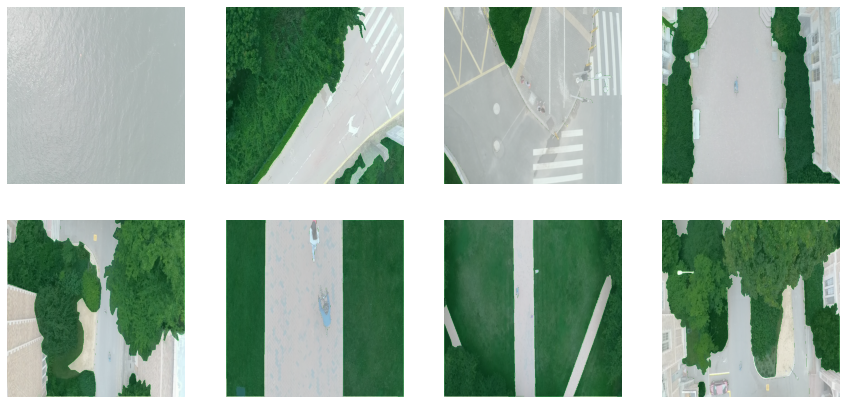

In [91]:
plt.figure(figsize=(15,15))

counter = 0
for k in range(batch_size):
  plt.subplot(4,4,counter+1)
  infile = np.random.choice(test_files, size = 1)[0]    
  x, y = get_pair(infile, 9, sz)
  plt.imshow(x,  cmap=plt.cm.gray)
  plt.imshow(y.squeeze(), alpha=0.5, cmap=plt.cm.Greens)
  plt.axis('off')
  counter += 1

Let's remind ourselves of the entire list. We're only using a couple of these

In [92]:
labs

['bckgrnd',
 'person',
 'bike',
 'car',
 'drone',
 'boat',
 'animal',
 'obstacle',
 'construction',
 'vegetation',
 'road',
 'sky']

## Test the models

I've commented the code below because it takes a very long time to execute (the test set is very large). But I have also pasted the scores I got when I ran the code

In [0]:
# test_batch_size = 32

# for c in ['vegetation', 'bckgrnd', 'construction', 'obstacle', 'road', 'sky']:

#     class_num =int(np.where(np.array(labs)==c)[0])
#     print(class_num) 

#     test_generator = image_batch_generator(test_files, class_num, sz, batch_size = test_batch_size)
#     # some other training parameters
#     steps = len(test_files) // test_batch_size

#     # testing
#     exec('scores = model_'+c+'.evaluate(test_generator, steps=steps)') 
#     print('loss={loss:0.4f}, Mean Dice={dice_coef:0.4f}'.format(loss=scores[0], dice_coef=scores[1]))

# 9
# 102/102 [==============================] - 569s 6s/step - loss: 0.0239 - dice_coef: 0.9761
# loss=0.0239, Mean Dice=0.9761
# 0
# 102/102 [==============================] - 576s 6s/step - loss: 0.0546 - dice_coef: 0.9454
# loss=0.0546, Mean Dice=0.9454
# 8
# 102/102 [==============================] - 570s 6s/step - loss: 0.1884 - dice_coef: 0.8116
# loss=0.1884, Mean Dice=0.8116
# 7
# 102/102 [==============================] - 581s 6s/step - loss: 0.3609 - dice_coef: 0.6391
# loss=0.3609, Mean Dice=0.6391
# 10
# 102/102 [==============================] - 581s 6s/step - loss: 0.0181 - dice_coef: 0.9819
# loss=0.0181, Mean Dice=0.9819
# 11
# 102/102 [==============================] - 577s 6s/step - loss: 0.2379 - dice_coef: 0.7621
# loss=0.2379, Mean Dice=0.7621


The workflow below will predict on a single sample image, for each of the classes, and upscale both the image `x`, ground truth label `y`, and model prediction `pred`, and collect them into lists

In [94]:
#I'm hard-coding an image in so we all get to look at the same thing
infile = 'aeroscapes/JPEGImages/041003_047.jpg'

# ... but ordinarily you'd probably select it randomly from the list of test files, 
# perhaps like this
#infile = np.random.choice(test_files, size = 1)[0]    

# the original image size (model training used 512 x 512)
orig_size = (720, 720)

# pre-allocate lists for modelled (M) and true (T) masks
M = []; T = []

counter = 1
for c in ['vegetation', 'bckgrnd', 'construction', 'obstacle', 'road', 'sky']:
    print("Working on %s" % (c))

    class_num =int(np.where(np.array(labs)==c)[0])
    print(class_num)

    x, _ = get_pair(infile, class_num, sz)
    exec('pred = model_'+c+'.predict(np.expand_dims(x, 0)).squeeze()') 
    resized_label = (np.array(Image.fromarray(pred).resize(orig_size, resample = Image.NEAREST))>.5)*counter
    M.append(resized_label)

    _, y = get_pair(infile, class_num, sz)
    T.append(((np.array(Image.fromarray(y*255.).resize(orig_size, resample = Image.NEAREST))/255.)>.5)*counter)
    counter += 1

Working on vegetation
9
Working on bckgrnd
0
Working on construction
8
Working on obstacle
7
Working on road
10
Working on sky
11


To get the label matrix we take the sum over the stacking dimension, which happens to be 0. This flattens the matrix down to 2D

In [0]:
M2 = np.sum(np.array(M), axis=0)

Next we need a new list of labels and assoociated colors

In [0]:
labs_new = ['unknown', 'vegetation', 'bckgrnd', 'construction', 'obstacle', 'road', 'sky'] 
cols_new = ['k', 'g', '#eebfca','r', 'm','#8a8d8d','c'] 

Make a new colormap

In [0]:
cmap_new = ListedColormap(cols_new)

clip the matrix so pixels classified as more than one thing are classified as zero, or `unknown`

In [0]:
M2[M2>len(labs_new)+1] = 0
M2[M2<0] = 0

Do the same for the ground truth matrix

In [0]:
T2 = np.sum(np.array(T), axis=0)
T2[T2>len(labs_new)+1] = 0

In [0]:
M2 = M2.astype('int')
T2 = T2.astype('int')

Check it out

[Text(1, 0, 'unknown'),
 Text(1, 0, 'vegetation'),
 Text(1, 0, 'bckgrnd'),
 Text(1, 0, 'construction'),
 Text(1, 0, 'obstacle'),
 Text(1, 0, 'road'),
 Text(1, 0, 'sky')]

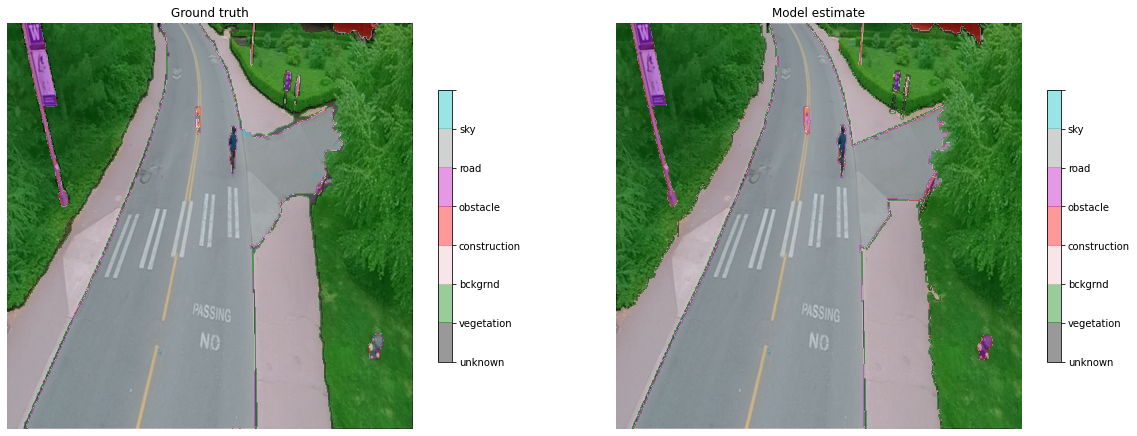

In [101]:
plt.figure(figsize=(20,20))

plt.subplot(121)
plt.imshow(Image.fromarray(x).resize(orig_size))
plt.imshow(M2, alpha=0.4, cmap=cmap_new, vmin=0, vmax=len(labs_new))
plt.axis('off')
plt.title('Ground truth')
cbar = plt.colorbar(shrink=0.25, ticks=np.arange(len(labs_new)+1))
cbar.ax.set_yticklabels(labs_new) 

plt.subplot(122)
plt.axis('off')
plt.imshow(Image.fromarray(x).resize(orig_size))
plt.imshow(T2, alpha=0.4, cmap=cmap_new, vmin=0, vmax=len(labs_new)) #plot mask with 40% transparency
plt.title('Model estimate')
cbar = plt.colorbar(shrink=0.25, ticks=np.arange(len(labs_new)+1))
cbar.ax.set_yticklabels(labs_new) 

Hmm, high frequency noise in both ground truth and label, presumably caused by the resizing. Let's use a median filter on the output to smooth over that

`scikit-image` has the tools we need, the median filter and the kernel - we use a disk with radius 15 pixels

In [0]:
from skimage.filters.rank import median
from skimage.morphology import disk

Apply, and visualize

In [103]:
M2 = median(M2, disk(15))
T2 = median(T2, disk(15))

/usr/local/lib/python3.6/dist-packages/skimage/filters/rank/generic.py:119: UserWarning: Possible precision loss converting image of type int64 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  out_dtype)
/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 7 fits in uint8
  return convert(image, np.uint8, force_copy)
/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 6 fits in uint8
  return convert(image, np.uint8, force_copy)


Text(0.5, 1.0, 'Model estimate')

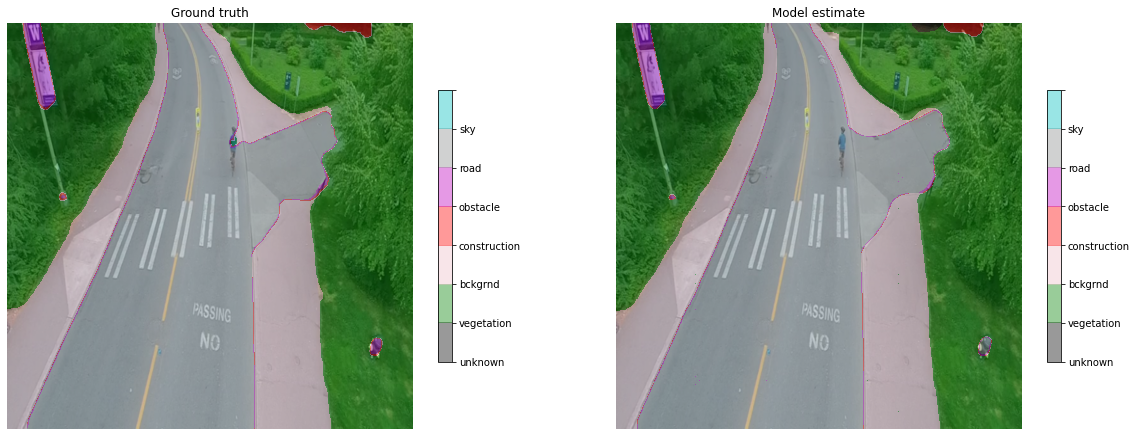

In [104]:
plt.figure(figsize=(20,20))
plt.subplot(121)
plt.axis('off')
plt.imshow(Image.fromarray(x).resize(orig_size))
plt.imshow(T2, alpha=0.4, cmap=cmap_new, vmin=0, vmax=len(labs_new)) #plot mask with 40% transparency
cbar = plt.colorbar(shrink=0.25, ticks=np.arange(len(labs_new)+1))
cbar.ax.set_yticklabels(labs_new)
plt.title('Ground truth') 

plt.subplot(122)
plt.axis('off')
plt.imshow(Image.fromarray(x).resize(orig_size))
plt.imshow(M2, alpha=0.4, cmap=cmap_new, vmin=0, vmax=len(labs_new)) #plot mask with 40% transparency
cbar = plt.colorbar(shrink=0.25, ticks=np.arange(len(labs_new)+1))
cbar.ax.set_yticklabels(labs_new) 
plt.title('Model estimate')

Much better. It is clear the model is as good if not better than the manual label

Let's use the same workflow to look at a few more, randomly selected from the test set

Working on image aeroscapes/JPEGImages/310014_024.jpg


/usr/local/lib/python3.6/dist-packages/skimage/filters/rank/generic.py:119: UserWarning: Possible precision loss converting image of type int64 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  out_dtype)
/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 6 fits in uint8
  return convert(image, np.uint8, force_copy)
/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 8 fits in uint8
  return convert(image, np.uint8, force_copy)


Working on image aeroscapes/JPEGImages/045002_040.jpg
Working on image aeroscapes/JPEGImages/200004_048.jpg


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 7 fits in uint8
  return convert(image, np.uint8, force_copy)


Working on image aeroscapes/JPEGImages/041001_063.jpg
Working on image aeroscapes/JPEGImages/213000_011.jpg
Working on image aeroscapes/JPEGImages/000004_039.jpg


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 5 fits in uint8
  return convert(image, np.uint8, force_copy)


Working on image aeroscapes/JPEGImages/041000_050.jpg
Working on image aeroscapes/JPEGImages/311000_052.jpg


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 2 fits in uint8
  return convert(image, np.uint8, force_copy)


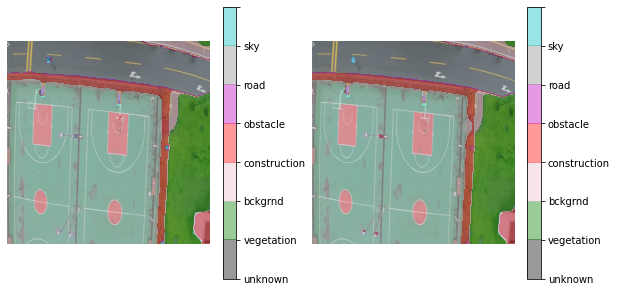

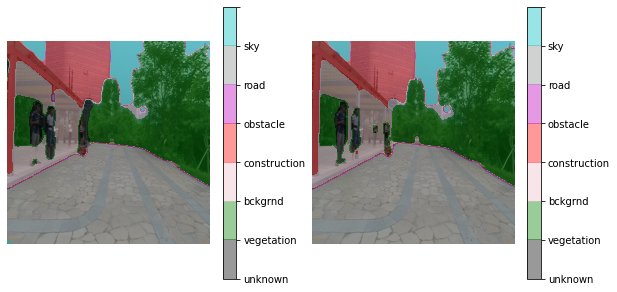

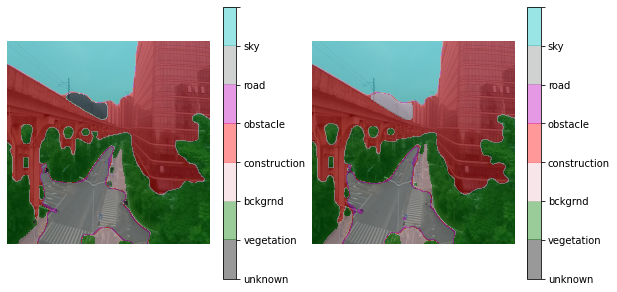

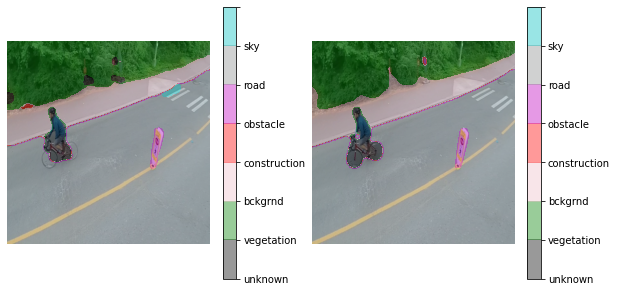

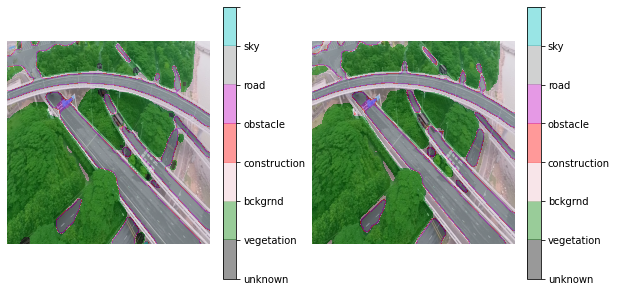

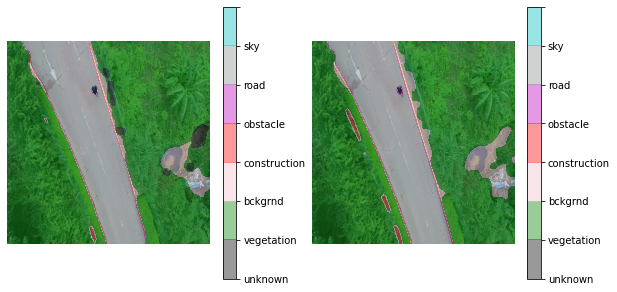

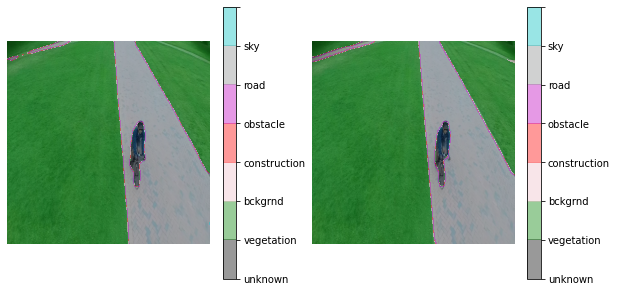

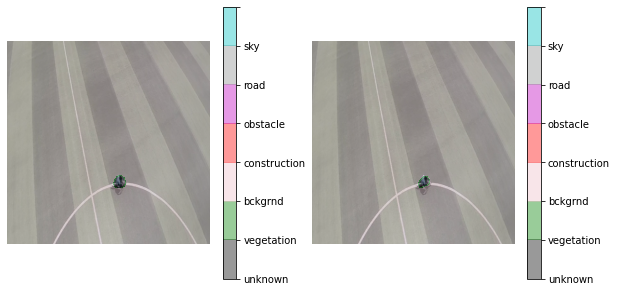

In [105]:
infiles = np.random.choice(test_files, size = 8)

for f in infiles:
    print("Working on image %s" % (f))
    M = []; T = []

    counter = 1
    for c in ['vegetation', 'bckgrnd', 'construction', 'obstacle', 'road', 'sky']:
        #print("Working on %s" % (c))
        class_num =int(np.where(np.array(labs)==c)[0])

        x, _ = get_pair(f, class_num, sz)
        exec('pred = model_'+c+'.predict(np.expand_dims(x, 0)).squeeze()') 
        resized_label = (np.array(Image.fromarray(pred).resize(orig_size, resample = Image.NEAREST))>.5)*counter
        M.append(resized_label)

        _, y = get_pair(f, class_num, sz)
        T.append(((np.array(Image.fromarray(y*255.).resize(orig_size, resample = Image.NEAREST))/255.)>.5)*counter)
        counter += 1


    M2 = np.sum(np.array(M), axis=0); M2[M2>len(labs_new)+1] = 0; M2[M2<0] = 0
    T2 = np.sum(np.array(T), axis=0); T2[T2>len(labs_new)+1] = 0; T2[T2<0] = 0

    M2 = M2.astype('int')
    T2 = T2.astype('int')

    T2 = median(T2, disk(15))
    M2 = median(M2, disk(15))

    plt.figure(figsize=(10,10))
    plt.subplot(121)
    plt.imshow(Image.fromarray(x).resize(orig_size))
    plt.imshow(M2, alpha=0.4, cmap=cmap_new, vmin=0, vmax=len(labs_new))
    plt.axis('off')
    cbar = plt.colorbar(shrink=0.5, ticks=np.arange(len(labs_new)+1))
    cbar.ax.set_yticklabels(labs_new) 

    plt.subplot(122)
    plt.axis('off')
    plt.imshow(Image.fromarray(x).resize(orig_size))
    plt.imshow(T2, alpha=0.4, cmap=cmap_new, vmin=0, vmax=len(labs_new)) #plot mask with 40% transparency
    cbar = plt.colorbar(shrink=0.5, ticks=np.arange(len(labs_new)+1))
    cbar.ax.set_yticklabels(labs_new) 

Pretty good, overall. How could we do better?

## Refining a segmentation using Conditional Random Fields

Below we use the same task-specific image segmentation algorithm used by [Buscombe and Ritchie (2018)](https://www.mdpi.com/2076-3263/8/7/244), called a fully connected Conditional Random Field, or CRF.

Here we'll zero out ambiguous areas (areas classified as more than one thing) and use it to estimate what those labels are, based on a model it will construct that describes the relationship between the the labels present in the label image, and image features (colors and textures), and their relative spatial locations. It's a really powerful model for lots of types of segmentation post-processing tasks. Be guided by your imagination. 

We only need to install one package, ```pydensecrf```, detailed [here](https://github.com/lucasb-eyer/pydensecrf)

In [106]:
!pip install pydensecrf

     |████████████████████████████████| 1.0MB 2.7MB/s 
  Created wheel for pydensecrf: filename=pydensecrf-1.0rc3-cp36-cp36m-linux_x86_64.whl size=2153755 sha256=769d3a923e58253ab0309194d6f755383666be680fa409ac96702b1022f082d7
  Stored in directory: /root/.cache/pip/wheels/92/6f/ec/5c49c25de8c42c872de50ff53582ba3ead850ce52a81e73ac7
Successfully built pydensecrf


then load the libraries we need from that package

In [0]:
from pydensecrf import densecrf
from pydensecrf.utils import unary_from_labels

We'll use a CRF model to refine both the UNet model predictions and the labels

The image and label data are mapped onto nodes of a graph
nearby grid nodes with similar image intensity, texture and color are likely to be in the same class. The degree of similarity is controlled by the parameter `theta_col` (non-dimensional). As `theta_col` increases, larger image differences are tolerated within the same class. 

`compat_col` is a parameter that controls label "compatibility",  by  imposing  a  penalty  for  similar  grid  nodes  that  are  assigned different labels. Similarity in this context is again based on similar image intensity, texture and colors 

As `theta_spat` (non-dimensional) increases, larger spatial differences are tolerated within the same class, and `compat_col` imposes a penalty for nearby nodes that are assigned different labels

`num_iter` is the number of iterations the model will take . Increasing this number increases the total inference time

In your own time, play with these parameters and measure the response

In [0]:
def crf_labelrefine(input_image, predicted_labels, num_classes):
    
    compat_spat = theta_spat = 1
    compat_col=40 
    theta_col = 40 
    num_iter = 30 
    
    h, w = input_image.shape[:2] #get image dimensions
    
    d = densecrf.DenseCRF2D(w, h, num_classes) #create a CRF object

    # For the predictions, densecrf needs 'unary potentials' which are labels (water or no water)
    predicted_unary = unary_from_labels(predicted_labels.astype('int')+1, num_classes, gt_prob= 0.51)
    
    # set the unary potentials to CRF object
    d.setUnaryEnergy(predicted_unary)

    # to add the color-independent term, where features are the locations only:
    d.addPairwiseGaussian(sxy=(theta_spat, theta_spat), compat=compat_spat, kernel=densecrf.DIAG_KERNEL,
                          normalization=densecrf.NORMALIZE_SYMMETRIC)

    input_image_uint = (input_image * 255).astype(np.uint8) #enfore unsigned 8-bit
    # to add the color-dependent term, i.e. 5-dimensional features are (x,y,r,g,b) based on the input image:    
    d.addPairwiseBilateral(sxy=(theta_col, theta_col), srgb=(5, 5, 5), rgbim=input_image_uint,
                           compat=compat_col, kernel=densecrf.DIAG_KERNEL, 
                           normalization=densecrf.NORMALIZE_SYMMETRIC)

    # Finally, we run inference to obtain the refined predictions:
    refined_predictions = np.array(d.inference(num_iter)).reshape(num_classes, h, w)
    
    # since refined_predictions will be a 2 x width x height array, 
    # each slice respresenting probability of each class (water and no water)
    # therefore we return the argmax over the zeroth dimension to return a mask
    return np.argmax(refined_predictions,axis=0)

The function will implement the same as above, with the additional step of applying the CRF to both the ground truth and predicted labels

Working on image aeroscapes/JPEGImages/040001_035.jpg


/usr/local/lib/python3.6/dist-packages/skimage/filters/rank/generic.py:119: UserWarning: Possible precision loss converting image of type int64 to uint8 as required by rank filters. Convert manually using skimage.util.img_as_ubyte to silence this warning.
  out_dtype)
/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 6 fits in uint8
  return convert(image, np.uint8, force_copy)
/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 7 fits in uint8
  return convert(image, np.uint8, force_copy)


Working on image aeroscapes/JPEGImages/000102_027.jpg


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 8 fits in uint8
  return convert(image, np.uint8, force_copy)


Working on image aeroscapes/JPEGImages/002001_013.jpg
Working on image aeroscapes/JPEGImages/035001_012.jpg


/usr/local/lib/python3.6/dist-packages/skimage/util/dtype.py:503: UserWarning: Downcasting int64 to uint8 without scaling because max value 5 fits in uint8
  return convert(image, np.uint8, force_copy)


Working on image aeroscapes/JPEGImages/045002_050.jpg
Working on image aeroscapes/JPEGImages/310015_008.jpg
Working on image aeroscapes/JPEGImages/040003_012.jpg
Working on image aeroscapes/JPEGImages/041008_002.jpg


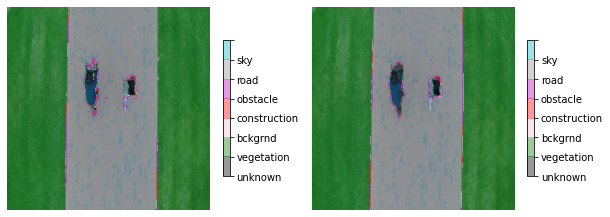

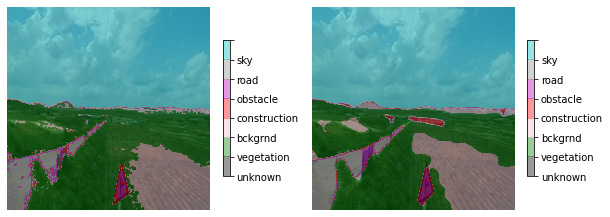

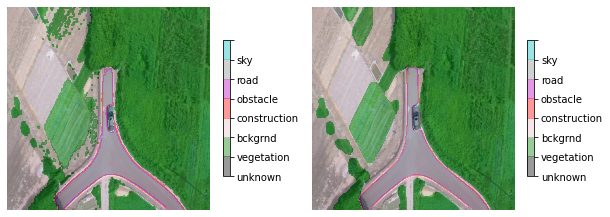

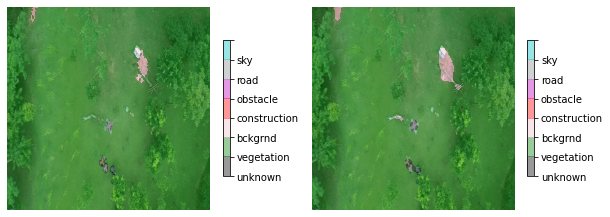

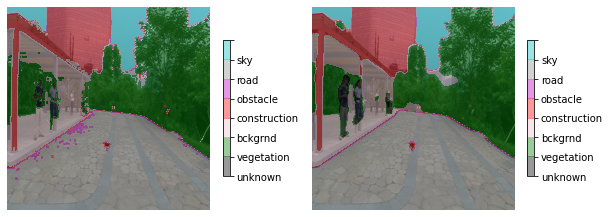

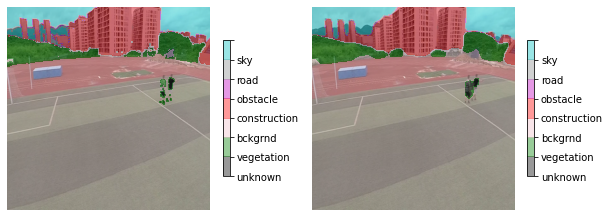

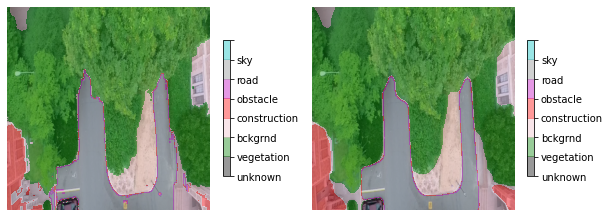

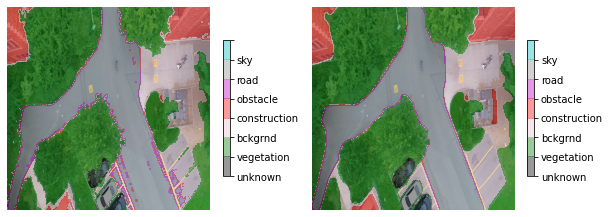

In [112]:
infiles = np.random.choice(test_files, size = 8)

for f in infiles:
    print("Working on image %s" % (f))
    M = []; T = []

    counter = 1
    for c in ['vegetation', 'bckgrnd', 'construction', 'obstacle', 'road', 'sky']:
        class_num =int(np.where(np.array(labs)==c)[0])

        x, _ = get_pair(f, class_num, sz)
        exec('pred = model_'+c+'.predict(np.expand_dims(x, 0)).squeeze()') 
        resized_label = (np.array(Image.fromarray(pred).resize(orig_size, resample = Image.NEAREST))>.5)*counter
        M.append(resized_label)

        _, y = get_pair(f, class_num, sz)
        T.append(((np.array(Image.fromarray(y*255.).resize(orig_size, resample = Image.NEAREST))/255.)>.5)*counter)
        counter += 1


    M2 = np.sum(np.array(M), axis=0); M2[M2>len(labs_new)+1] = 0; M2[M2<0] = 0
    T2 = np.sum(np.array(T), axis=0); T2[T2>len(labs_new)+1] = 0; T2[T2<0] = 0

    M2 = M2.astype('int')
    T2 = T2.astype('int')

    T2 = median(T2, disk(15))
    M2 = median(M2, disk(15))

    x = np.array(Image.fromarray(x).resize(orig_size))

    predicted_labels = M2.astype('int')
    predicted_labels[predicted_labels<0] = 0
    M2 = crf_labelrefine(x, predicted_labels, len(labs_new)+1)

    true_labels = T2.astype('int')
    true_labels[true_labels<0] = 0
    M2 = crf_labelrefine(x, true_labels, len(labs_new)+1)

    plt.figure(figsize=(10,10))
    plt.subplot(121)
    plt.imshow(x)
    plt.imshow(M2, alpha=0.4, cmap=cmap_new, vmin=0, vmax=len(labs_new))
    plt.axis('off')
    cbar = plt.colorbar(shrink=0.25, ticks=np.arange(len(labs_new)+1))
    cbar.ax.set_yticklabels(labs_new) 

    plt.subplot(122)
    plt.axis('off')
    plt.imshow(x)
    plt.imshow(T2, alpha=0.4, cmap=cmap_new, vmin=0, vmax=len(labs_new)) #plot mask with 40% transparency
    cbar = plt.colorbar(shrink=0.25, ticks=np.arange(len(labs_new)+1))
    cbar.ax.set_yticklabels(labs_new) 

That is the end! Hope you enjoyed it and found it useful